---
output:
  html:
    self-contained: true
  pdf:
    toc: true
---

# Simulating new preference groups

Two options:

1. run RCV algo first, and then take the resulting beliefs about election results as 'ground zero' for a plurality algo
2.  generate random preference profiles

This notebook explores option 2.

In [20]:
# Load dependencies
library(tidyverse)
library(gtools)
library(ggtern)
library(pivotprobs)
library(questionr)

# Load SV script
setwd("~/github/strategicvoting/")
source("code/utils/new_sv_iter.R")

## Visualising existing preferences



In [21]:
# Load all of the existing preference data

load("output/big_list_2.RData")
vap <- read.csv("data/case_vap.csv", sep = "") # voting age pop.
cat("Data imported. \n")
source("code/prep_cses.R")  # data prep

Data imported. 


Joining, by = "cntry"


big_list_na_omit prepared. 


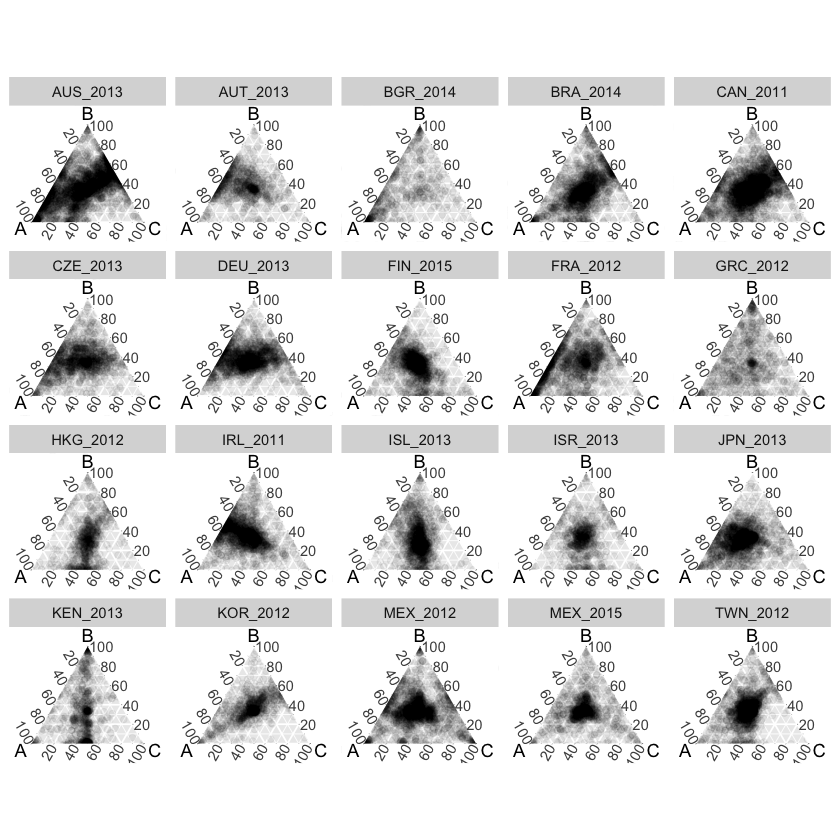

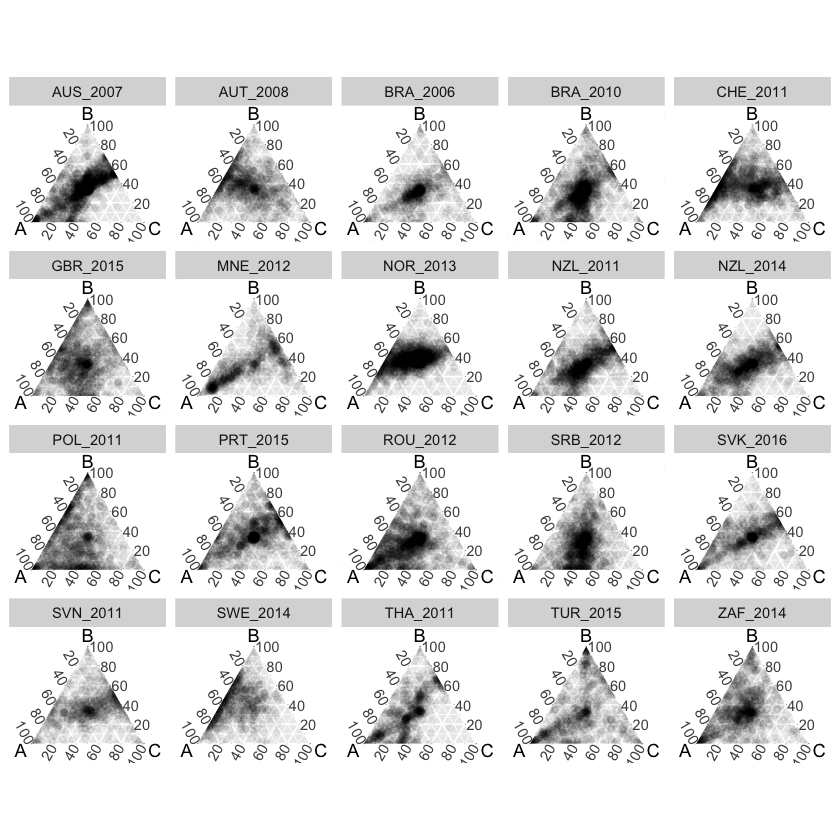

In [22]:
# Visualising all 160 preference distributions...

big_U <- map_dfr(big_list_na_omit[1:20], ~ .x$U, .id = "case")

ggtern(big_U, aes(A, B, C)) +
  facet_wrap(~ case) +
  geom_point(alpha = 0.05)

big_U <- map_dfr(big_list_na_omit[21:40], ~ .x$U, .id = "case")

ggtern(big_U, aes(A, B, C)) +
  facet_wrap(~ case) +
  geom_point(alpha = 0.05)

## Approach 1

The first is a relatively naive way of simulating preferences -- we assume that voters cluster into 6 groups, roughly corresponding to ABC, ACB, etc. types. 
For now, these are of equal size in expectation, but we can change that later, of course.

The idea here is that we want to model a pretty random distribution of preferences without much structure.

In [23]:
# Example of dirichlet draws

# Generate random distribution of survey respondents' preferences
gen_random_dist <- function(n = 100, n_alt = NULL){

  # Draw k = 6 dirichlet vectors (later versions can modify this parameter)
  # These are the hyperparameters that represent voter 
  # types' average preferences
  # In extension, can also refine into c(6, 1, 2) and c(6, 2, 1) for example

  if (is.null(n_alt)){
    n_alt <- rep(100, 6)
  }

  d <- rdirichlet(2, c(6, 2, 2)) %>% as.data.frame()
  d2 <- rdirichlet(2, c(2, 6, 2)) %>% as.data.frame()
  d3 <- rdirichlet(2, c(2, 2, 6)) %>% as.data.frame()
  d <- rbind(d, d2, d3) %>%
    mutate(n = n_alt, id = 1:6)

  # For each of the 6 seed vectors, simulate 100 preferences (i.e., 100 voters each)
  sims <- d %>%
    rowwise() %>%
    mutate(
      new_df = rdirichlet(
        # The factor here determines how strongly preferences are 
        # clustered. Again, something that we may want to decide to keep
        # as a parameter later on.
        n, c(V1, V2, V3) * runif(1, min = 10, max = 60)
      ) %>%
        as.data.frame() %>%
        mutate(
          id = as.factor(id)
        ) %>%
        list()
    )

  # Put everything together
  pref_data <- sims %>%
    select(new_df) %>%
    unnest(cols = c(new_df)) 

  return(pref_data)
}


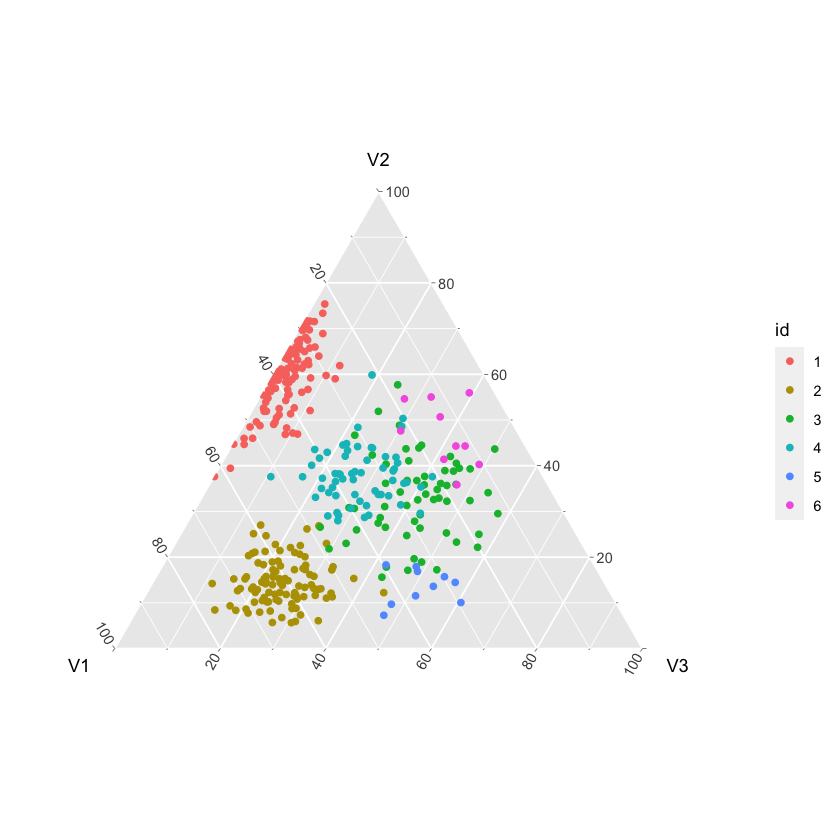

In [24]:
# Example run
dat <- gen_random_dist(n_alt = c(100, 100, 60, 60, 10, 10))

ggtern(dat, aes(V1, V2, V3)) +
    geom_point(aes(colour = id))

In [26]:
# Generate 100 random samples

dat_list <- replicate(100, gen_random_dist(n_alt = c(100, 100, 80, 80, 40, 40)), simplify = FALSE)

In [27]:
# Can I actually simulate strategic voting incentives on this thing?

dat_summary <- map(dat_list[1:20], ~ {

  # Compute strategic incentives
  out <- sv_iter(
    U = .x[, 1:3],
    s = 85,
    max.iterations = 40,
    rule = "AV",
    lambda = 0.05
  )

  out_plur <- sv_iter(
    U = .x[, 1:3],
    max.iterations = 40,
    s = 85,
    rule = "plurality",
    lambda = 0.05
  )

  irv_incentives <- map_dbl(out, ~ mean(.x$tau > 0))
  irv_mag <- map_dbl(out, ~ mean(.x$tau[.x$tau > 0]))
  plur_incentives <- map_dbl(out_plur, ~ mean(.x$tau > 0))
  plur_mag <- map_dbl(out_plur, ~ mean(.x$tau[.x$tau > 0]))

  return(
    data.frame(
      tau = c(irv_incentives, plur_incentives),
      mag = c(irv_mag, plur_mag),
      iter = rep(1:40, 2),
      system = rep(c("irv", "plur"), each = 40)
    )
  )
  }
)


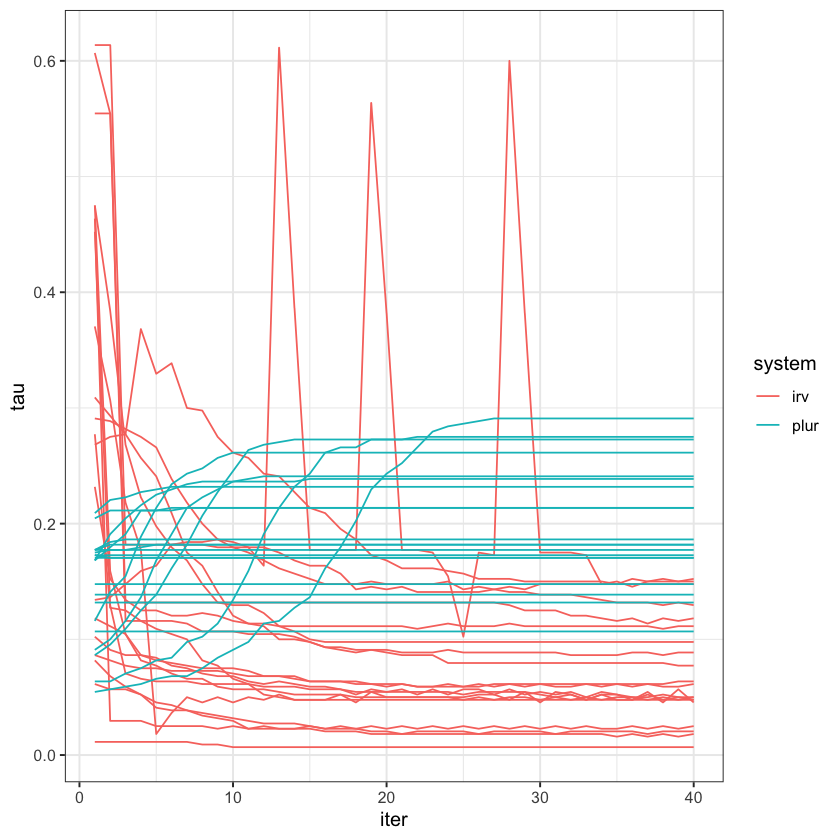

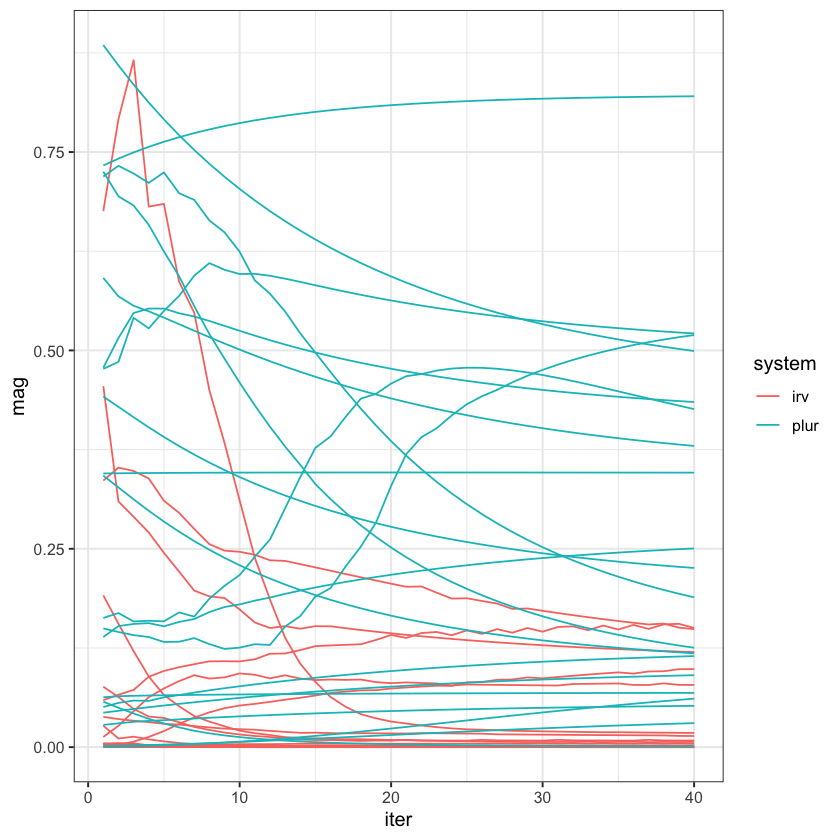

In [28]:
big_df <- map_dfr(
  dat_summary,
  .id = "case",
  ~ .x
)

# Incentives to vote strategically
ggplot(big_df, aes(x = iter, y = tau)) +
  geom_line(aes(group = interaction(case, system), colour = system)) +
  theme_bw()

# Magnitude of incentives
ggplot(big_df, aes(x = iter, y = mag)) +
  geom_line(aes(group = interaction(case, system), colour = system)) +
  theme_bw()


# Approach 2: Drawing preferences from beta distributions

Another approach puts more structure onto the problem, but may be too constraining. The idea is that we define each voter type's expected preference vector by drawing from beta distributions. For example, let's say that the modal BAC voter has $U(B) = 7$. We then draw from a beta distribution to get a value between 0 and 1 to simulate what factor of the first preference the second one is (e.g. if the drawn parameter is 0.5, then $U(A) = 7/2 = 3.5$).

To draw from beta distributions centred on mode $p$, I use the fact that for $\mathrm{Beta}(\alpha, \beta)$:

$$
\alpha = (c - 2) * p + 1
$$

and 

$$
\beta = (c - 1) - (c - 2) * p
$$

where $c$ is an arbitrary constant that defines the variance around the mode.

In [29]:
# Return parameters subject to mode being equal 
# to prior draw and alpha + beta = constraint
# prob = desired mode
# param = whether to return alpha or beta param
# constraint = defines how tight dist around mode is
new_beta <- function(prob, param, constraint = 10){
  if(param == "alpha"){
    return((constraint - 2) * prob + 1)
  } else if (param == "beta") {
     return((constraint - 1) - (constraint - 2) * prob)
  }
}

# new_df <- data.frame(x = rbeta(1000, new_beta(0.8, "alpha"), new_beta(0.8, "beta")))

# ggplot(new_df, aes(x = x)) +
#   geom_histogram()

# new_df <- data.frame(x = rbeta(100000, 10, 2))

# ggplot(new_df, aes(x = x)) +
#   geom_density()

In [30]:
# A more structured approach.
gen_structured_dist <- function(n = 100){

  # Simulate strength of each bloc:
  vvec_dist <- rdirichlet(1, rep(1, times = 6))

  # Simulate two pref intensities:
  pint1 <- rbeta(6, 1.1, 1.1)
  pint2 <- rbeta(6, 1.1, 1.1)

  # Simulate mean intensity of first preference
  pstart <- rbeta(6, 5, 2)

  mat <- matrix(NA, nrow = n, ncol = 3)

  for (i in 1:n) {

    # determine type
    t <- sample(1:6, size = 1, prob = vvec_dist)

    # get strength
    pref1 <- rbeta(1, new_beta(pstart[t], "alpha"), new_beta(pstart[t], "beta"))
    pref2 <- pref1 * rbeta(1, new_beta(pint1[t], "alpha"), new_beta(pint1[t], "beta"))
    pref3 <- pref2 * rbeta(1, new_beta(pint2[t], "alpha"), new_beta(pint2[t], "beta"))

    if (t == 1) { # ABC type
      mat[i, ] <- c(pref1, pref2, pref3)
    }
    if (t == 2) { # ACB type
      mat[i, ] <- c(pref1, pref3, pref2)
    }
    if (t == 3) { # BAC type
      mat[i, ] <- c(pref2, pref1, pref3)
    }
    if (t == 4) { # BCA type
      mat[i, ] <- c(pref3, pref1, pref2)
    }
    if (t == 5) { # CAB type
      mat[i, ] <- c(pref2, pref3, pref1)
    }
    if (t == 6) { # CBA type
      mat[i, ] <- c(pref3, pref2, pref1)
    }
  }

return(
  list(
    pmat = mat,
    vvec = vvec_dist
  )
)
}

,V1,V2,V3
,<dbl>,<dbl>,<dbl>
1,0.5154600,5.675685,0.9894151
2,1.0224816,4.249036,0.4682815
3,0.1133249,1.704418,6.9554763
4,8.7053273,2.332675,1.3598095
5,6.4811228,3.043509,1.8389404
6,0.9425290,2.464049,9.2772211


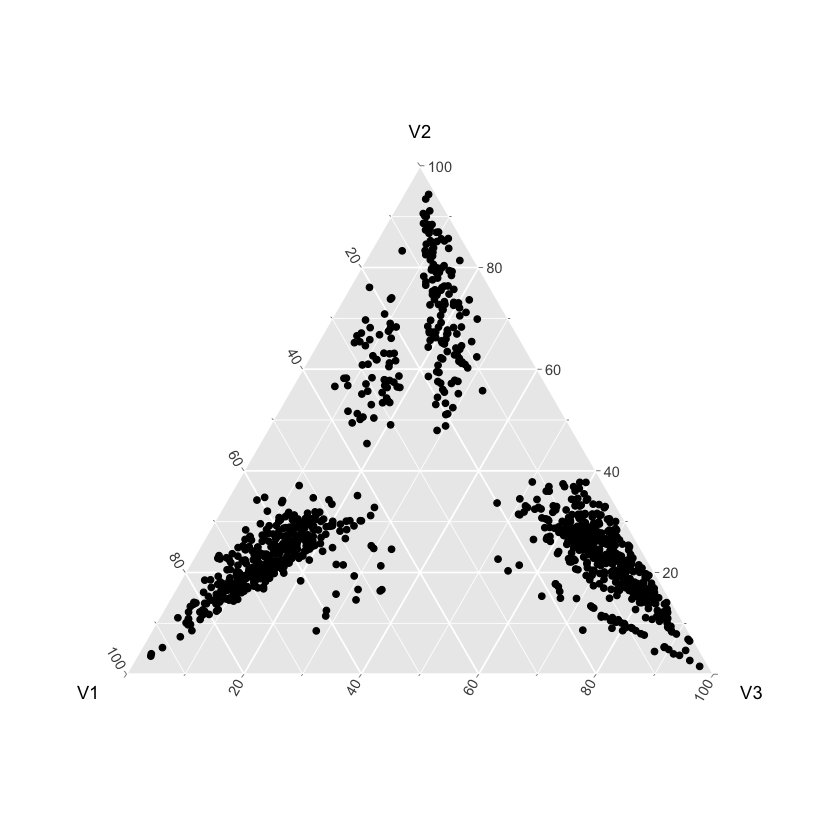

In [31]:
example_mat <- as.data.frame(gen_structured_dist(n = 1000)$pmat * 10)
head(example_mat)

rsum <- rowSums(example_mat)
example_mat <- example_mat %>%
  mutate_all(~ . / rsum)

ggtern(example_mat, aes(V1, V2, V3)) +
  geom_point()